In [48]:
#Importing all necessary libs
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import collections

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline


Loading BokehJS ...

In [5]:
datafile = '/home/fractaluser/Downloads/LDA using news headlines/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()


,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [6]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


In [8]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)


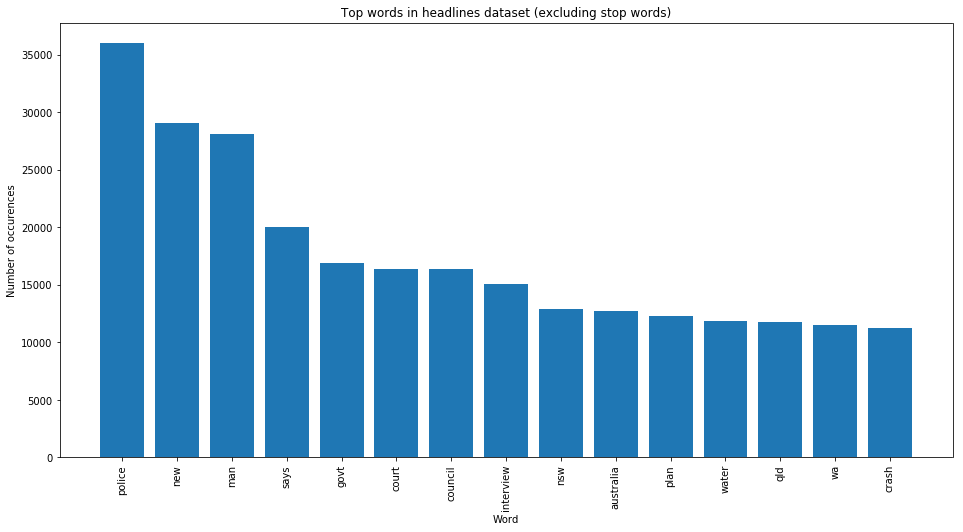

In [9]:
#Plotting top 15 most occuring words from the corpus. 
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()


Next we generate a histogram of headline word lengths, and use part-of-speech tagging to understand the types of words used across the corpus. This requires first converting all headline strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each headline.

In [14]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [16]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

In [18]:
word_counts = [] 
pos_counts = {}
for headline in tagged_headlines_df['tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1


In [23]:
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline:  ', np.mean(word_counts))


Total number of words:  7079566
Mean number of words per headline:  6.414608444787947


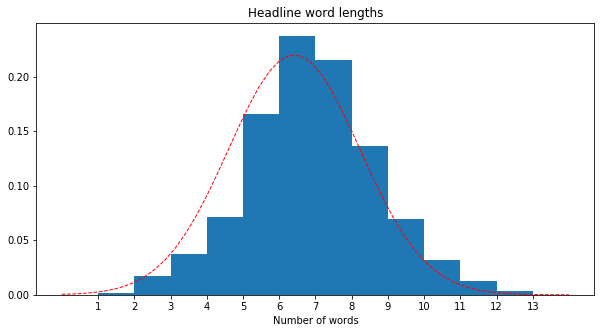

In [46]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

In [64]:
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)
pos_sorted_types = sorted(pos_counts, key=pos_counts.get, reverse=True)

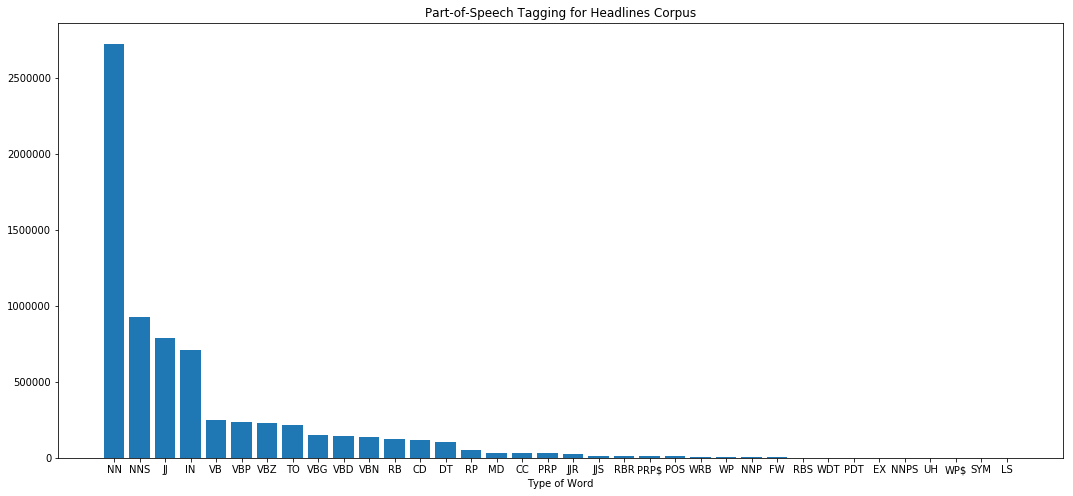

In [65]:
fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');


### Topic Modelling
We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.




#### Preprocessing
The only preprocessing step required in our case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the CountVectorizer object from SKLearn, which yields an  n×K  document-term matrix where  K  is the number of distinct words across the  n  headlines in our sample (less stop words and with a limit of max_features).


In [73]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)


We have our (very high-rank and sparse) training data,  small_document_term_matrix, and can now actually implement a clustering algorithm. Our choice will be either Latent Semantic Analysis or Latent Dirichilet Allocation. Both will take our document-term matrix as input and yield an  n×N  topic matrix as output, where  N  is the number of topic categories (which we supply as a parameter). For the moment, we shall take this to be 8.

In [71]:
n_topics = 8

In [78]:
# Define helper functions

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


In [93]:
# Define helper functions
def get_top_n_words_lda(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words


In [76]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)


In [79]:
lda_keys = get_keys(lda_topic_matrix)

In [105]:
count_pairs = Counter(lda_keys).items()
lda_categories = [pair[0] for pair in count_pairs]
lda_counts = [pair[1] for pair in count_pairs]

In [94]:
top_n_words_lda = get_top_n_words_lda(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

In [96]:
for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])


Topic 1:  police child calls day court says abuse dead change market
Topic 2:  council court coast murder gold government face says national police
Topic 3:  man charged police nsw sydney home road hit crash guilty
Topic 4:  says wa death sa abc australian report open sex final
Topic 5:  new qld election ban country future trial end industry hour
Topic 6:  interview australia world cup china south accused pm hill work
Topic 7:  police health govt hospital plan boost car minister school house
Topic 8:  new water killed high attack public farmers funding police urged


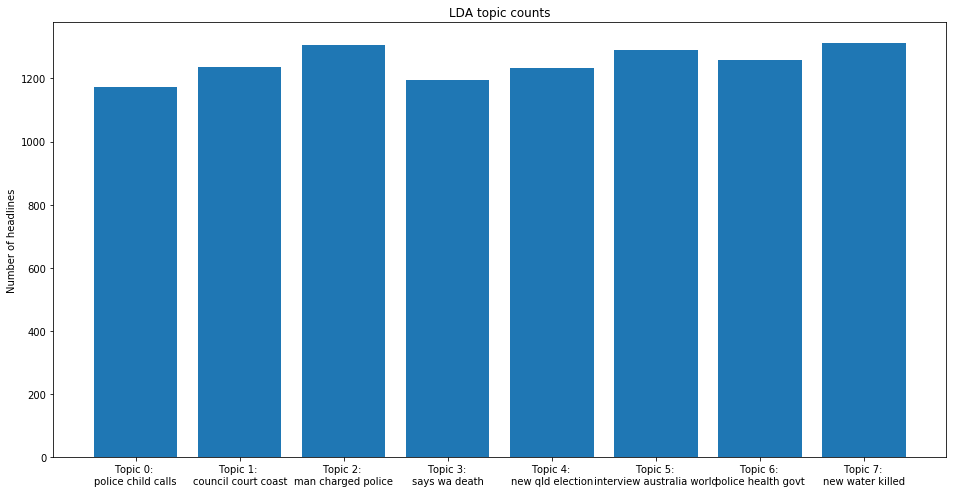

In [106]:
top_3_words = get_top_n_words_lda(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');